In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

# %matplotlib qt
%matplotlib inline

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (6,9), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (6,9), corners, ret)
        
cv2.destroyAllWindows()

In [28]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [10]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

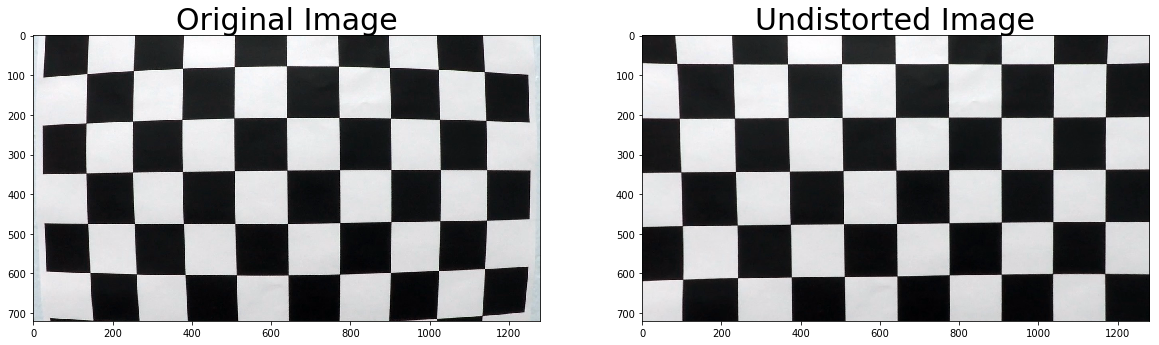

In [15]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undist = undistort(img, mtx, dist)
cv2.imwrite('camera_cal/calibration1_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

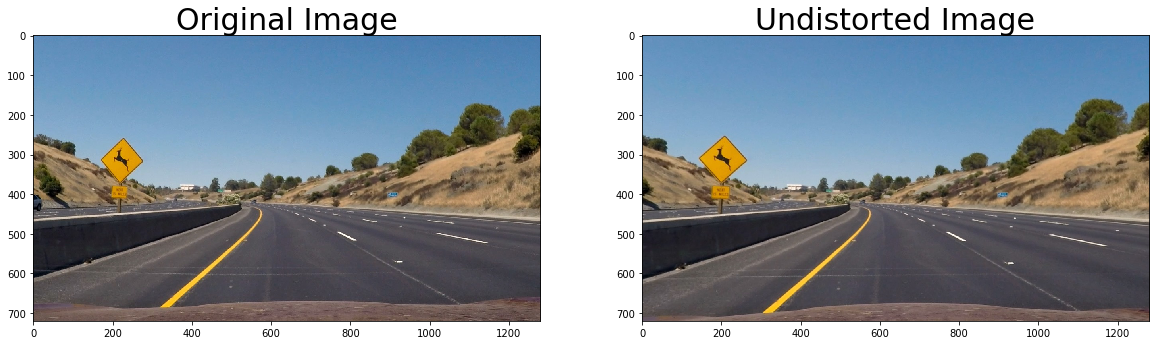

In [22]:
img = mpimg.imread('test_images/test2.jpg')

# Use the undistort function, with the mtx and dist calculated above
undist = undistort(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

In [24]:
def add_points(img, src):
    img2 = np.copy(img)
    color = [255, 0, 0] # Red
    thickness = -1
    radius = 15
    x0, y0 = src[0]
    x1, y1 = src[1]
    x2, y2 = src[2]
    x3, y3 = src[3]
    cv2.circle(img2, (x0, y0), radius, color, thickness)
    cv2.circle(img2, (x1, y1), radius, color, thickness)
    cv2.circle(img2, (x2, y2), radius, color, thickness)
    cv2.circle(img2, (x3, y3), radius, color, thickness)
    return img2

def add_lines(img, src):
    img2 = np.copy(img)
    color = [255, 0, 0] # Red
    thickness = 2
    x0, y0 = src[0]
    x1, y1 = src[1]
    x2, y2 = src[2]
    x3, y3 = src[3]
    cv2.line(img2, (x0, y0), (x1, y1), color, thickness)
    cv2.line(img2, (x1, y1), (x2, y2), color, thickness)
    cv2.line(img2, (x2, y2), (x3, y3), color, thickness)
    cv2.line(img2, (x3, y3), (x0, y0), color, thickness)
    return img2

In [25]:
src = np.float32(
[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

def warper(img):
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img):
    
    # Compute and apply inverse perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)
    
    return unwarped

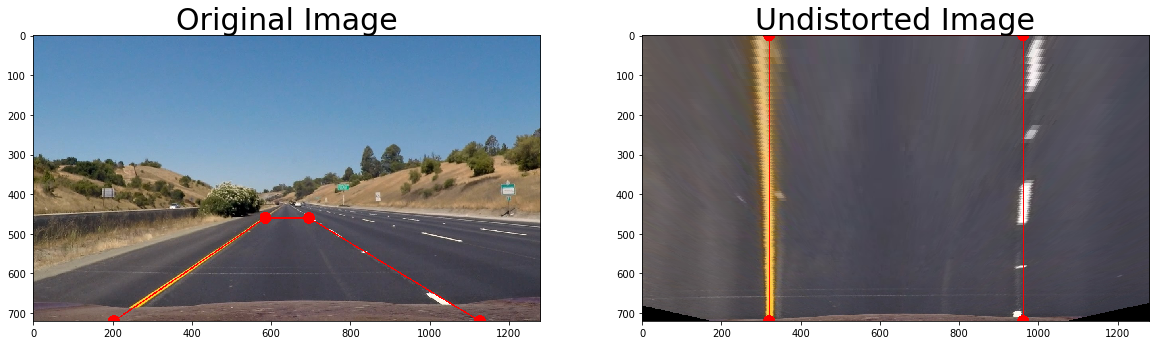

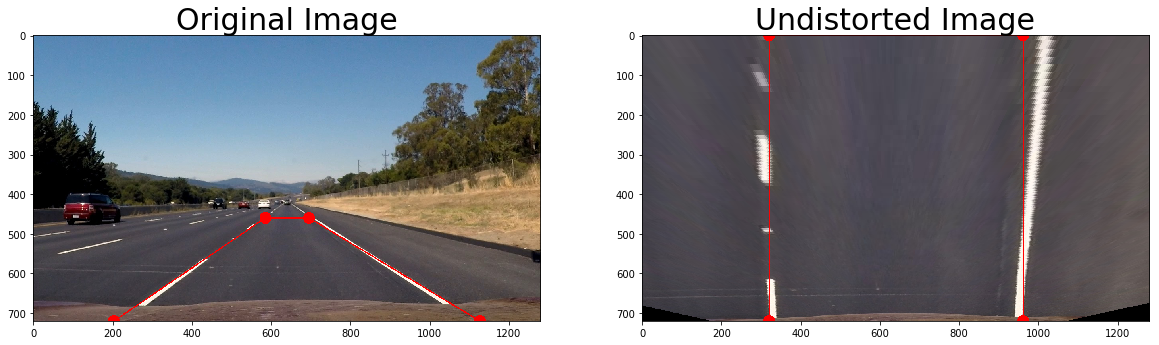

In [32]:
# get the straight test images from the test_images folder
images = glob.glob('test_images/straight*.jpg')

for fname in images:
    
    img = mpimg.imread(fname)
    
    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)
    
    # warp the image
    warped = warper(undist)

    # add the points to the og and warped images 
    src_points_img = add_points(img, src)
    src_points_img = add_lines(src_points_img, src)
    dst_points_warped = add_points(warped, dst)
    dst_points_warped = add_lines(dst_points_warped, dst)
    
    # Visualize the original image and the warped image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(src_points_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst_points_warped)
    ax2.set_title('Undistorted Image', fontsize=30)

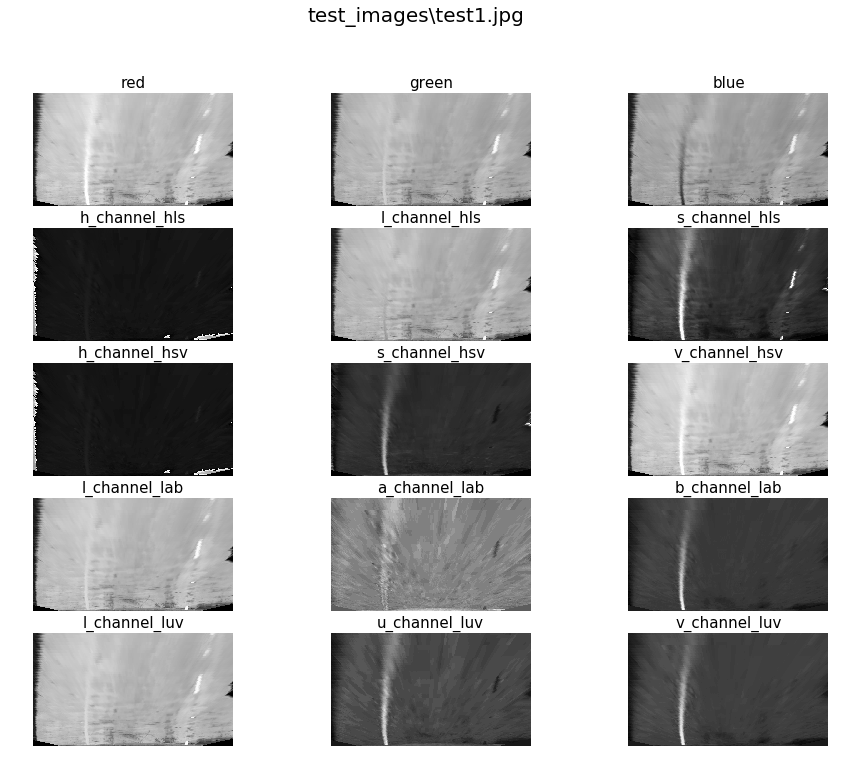

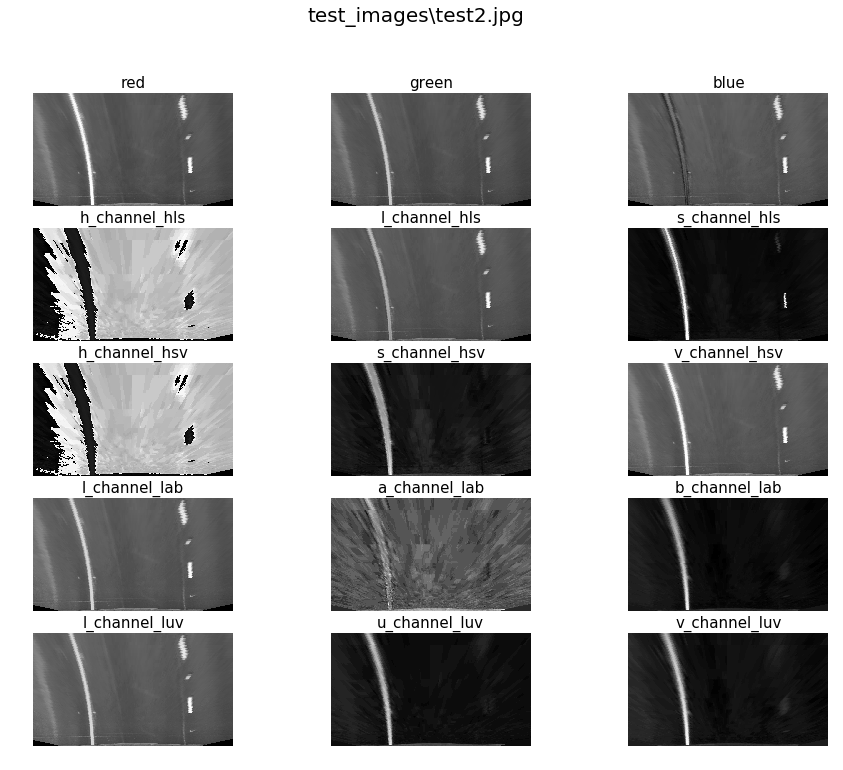

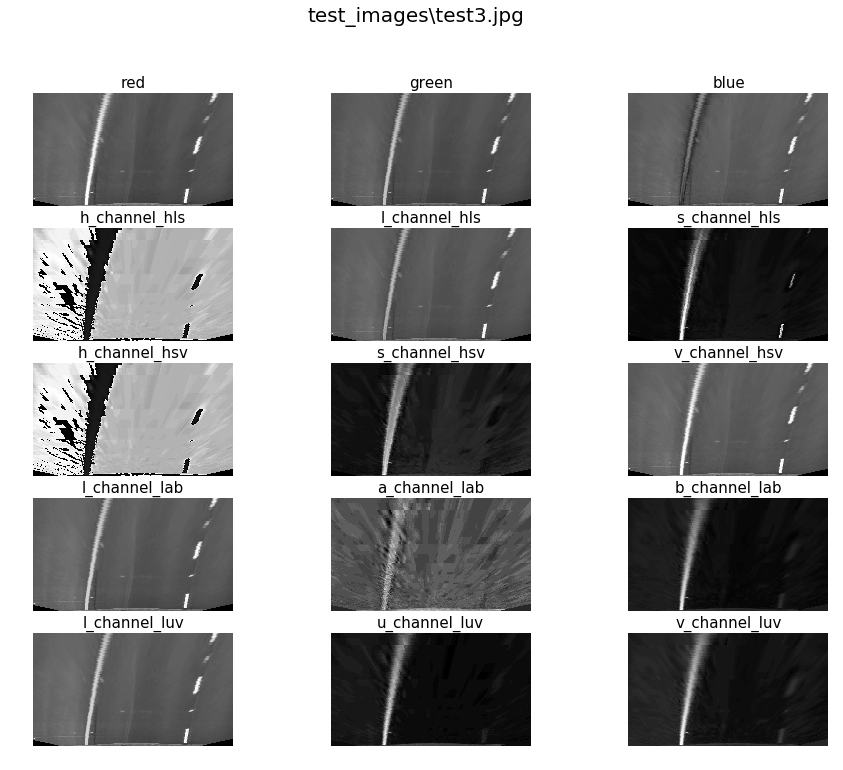

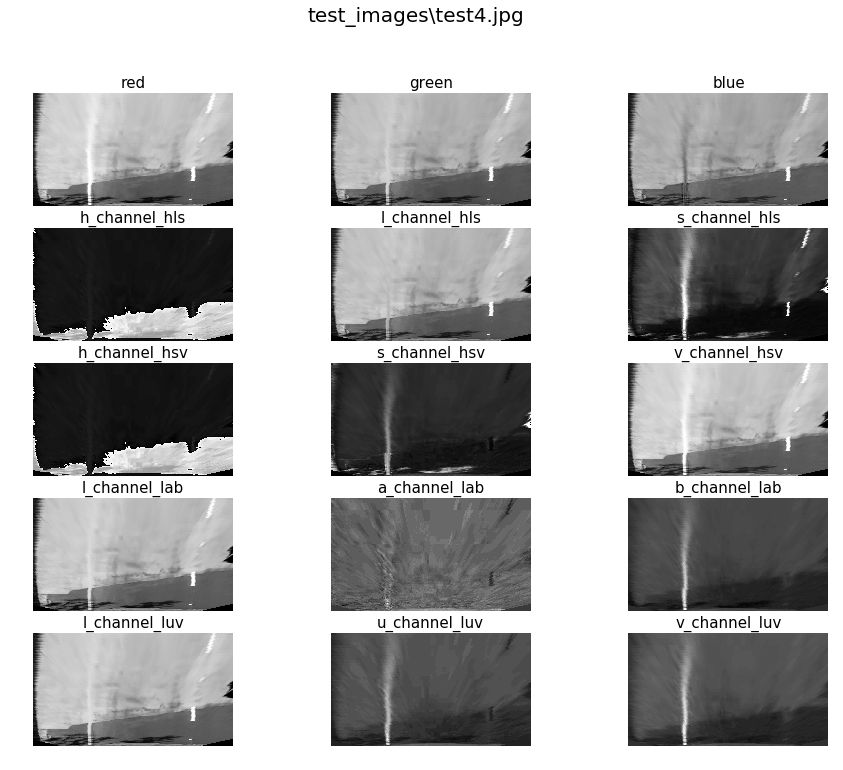

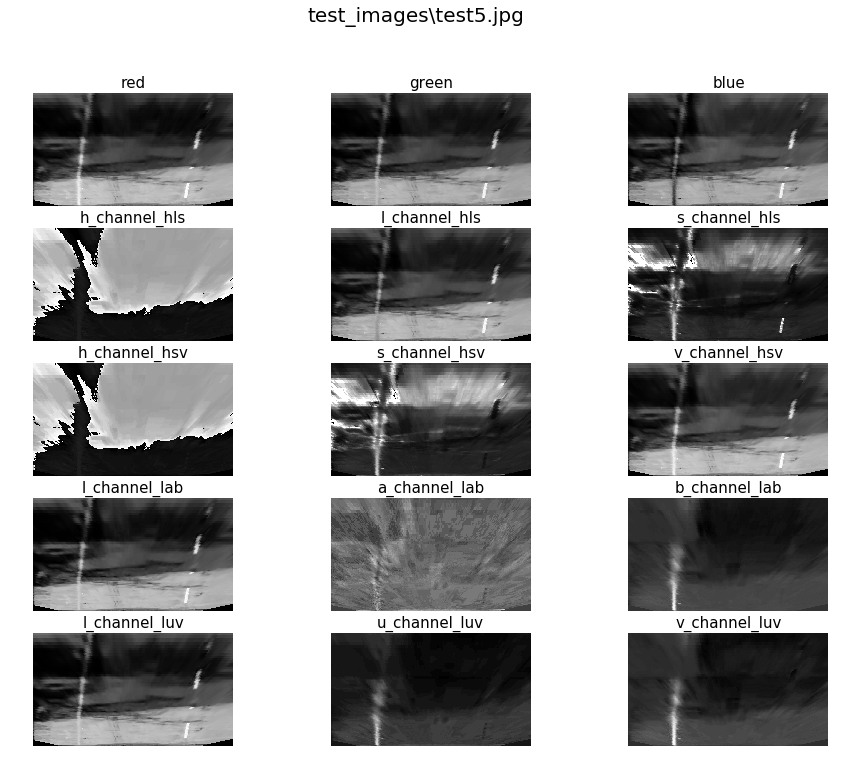

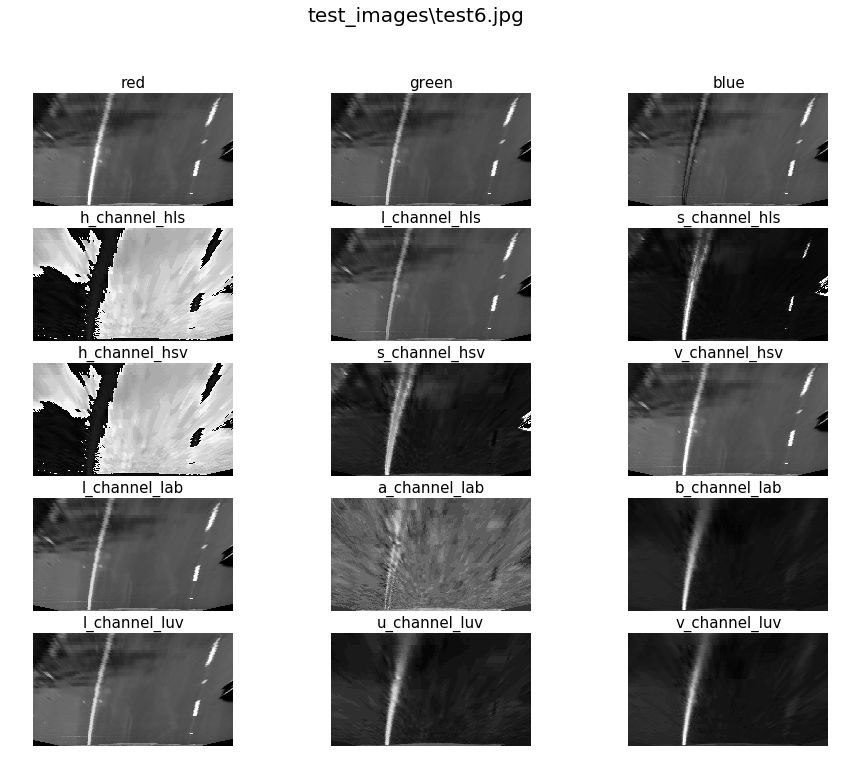

In [36]:
# get the test images from the test_images folder
images = glob.glob('test_images/test*.jpg')

# Loop through each image and send it to the pipeline
for fname in images:
    
    img = mpimg.imread(fname)
    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)
    # warp the image
    warped = warper(undist)

    # Separate the RGB
    R = warped[:,:,0]
    G = warped[:,:,1]
    B = warped[:,:,2]

    # Convert to HLS color space
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel_hls = hls[:,:,0]
    l_channel_hls = hls[:,:,1]
    s_channel_hls = hls[:,:,2]

    # Convert to HSV color space
    hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel_hsv = hsv[:,:,0]
    s_channel_hsv = hsv[:,:,1]
    v_channel_hsv = hsv[:,:,2]

    # Convert to LAB color space
    lab = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab).astype(np.float)
    l_channel_lab = lab[:,:,0]
    a_channel_lab = lab[:,:,1]
    b_channel_lab = lab[:,:,2]
    
    # Convert to LUV color space
    luv = cv2.cvtColor(warped, cv2.COLOR_RGB2Luv).astype(np.float)
    l_channel_luv = luv[:,:,0]
    u_channel_luv = luv[:,:,1]
    v_channel_luv = luv[:,:,2]

    
    ### Plot the source points on the original image and the warped image
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9),(ax10, ax11, ax12),(ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(16, 12))
    f.suptitle(fname, fontsize=20)
    
    
    # Visualize RGB
    ax1.imshow(R, cmap='gray')
    ax1.set_title('red', fontsize=15)
    ax1.axis('off')
    ax2.imshow(G, cmap='gray')
    ax2.set_title('green', fontsize=15)
    ax2.axis('off')
    ax3.imshow(B, cmap='gray')
    ax3.set_title('blue', fontsize=15)
    ax3.axis('off')
    
    # Visualize HLS colors
    ax4.imshow(h_channel_hls, cmap='gray')
    ax4.axis('off')
    ax4.set_title('h_channel_hls', fontsize=15)
    ax5.imshow(l_channel_hls, cmap='gray')
    ax5.set_title('l_channel_hls', fontsize=15)
    ax5.axis('off')
    ax6.imshow(s_channel_hls, cmap='gray')
    ax6.set_title('s_channel_hls', fontsize=15)
    ax6.axis('off')
    
    # Visualize HSV colors
    ax7.imshow(h_channel_hsv, cmap='gray')
    ax7.axis('off')
    ax7.set_title('h_channel_hsv', fontsize=15)
    ax8.imshow(s_channel_hsv, cmap='gray')
    ax8.set_title('s_channel_hsv', fontsize=15)
    ax8.axis('off')
    ax9.imshow(v_channel_hsv, cmap='gray')
    ax9.set_title('v_channel_hsv', fontsize=15)
    ax9.axis('off')
    
    # Visualize LAB colors
    ax10.imshow(l_channel_lab, cmap='gray')
    ax10.axis('off')
    ax10.set_title('l_channel_lab', fontsize=15)
    ax11.imshow(a_channel_lab, cmap='gray')
    ax11.axis('off')
    ax11.set_title('a_channel_lab', fontsize=15)
    ax12.imshow(b_channel_lab, cmap='gray')
    ax12.set_title('b_channel_lab', fontsize=15)
    ax12.axis('off')
    
    # Visualize LUV colors
    ax13.imshow(l_channel_luv, cmap='gray')
    ax13.axis('off')
    ax13.set_title('l_channel_luv', fontsize=15)
    ax14.imshow(u_channel_luv, cmap='gray')
    ax14.set_title('u_channel_luv', fontsize=15)
    ax14.axis('off')
    ax15.imshow(v_channel_luv, cmap='gray')
    ax15.set_title('v_channel_luv', fontsize=15)
    ax15.axis('off')
    
    plt.subplots_adjust(hspace = .2, wspace=.001)

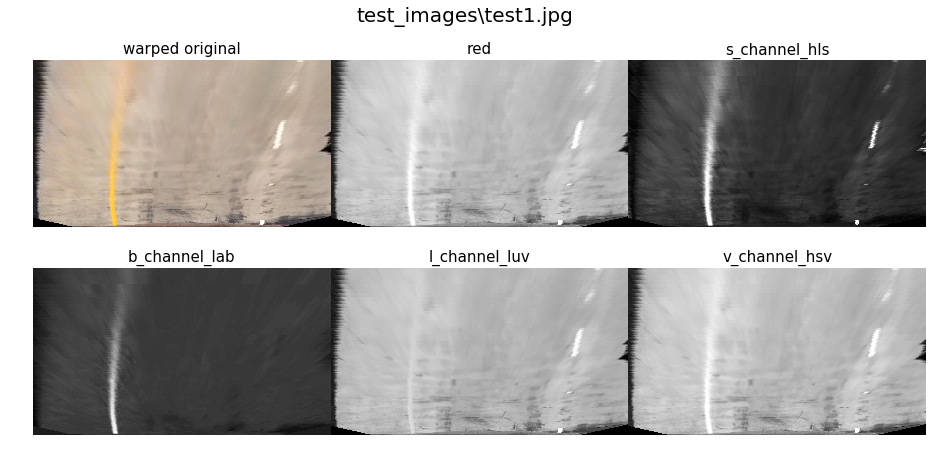

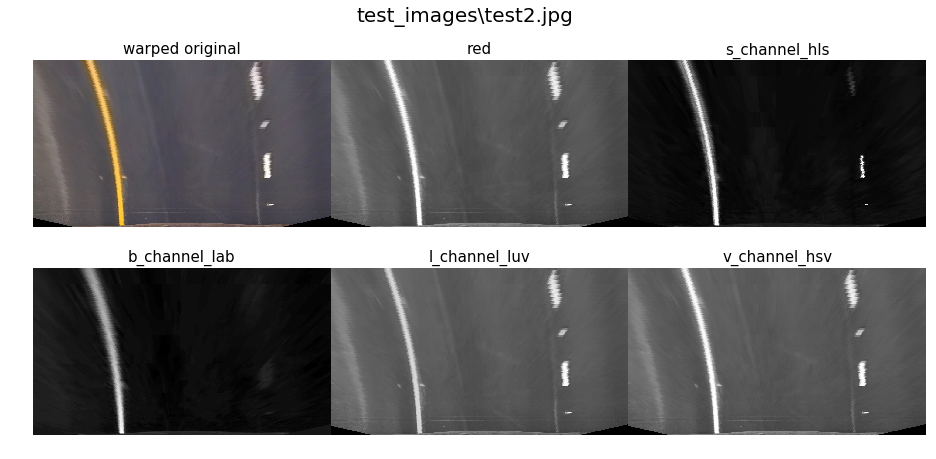

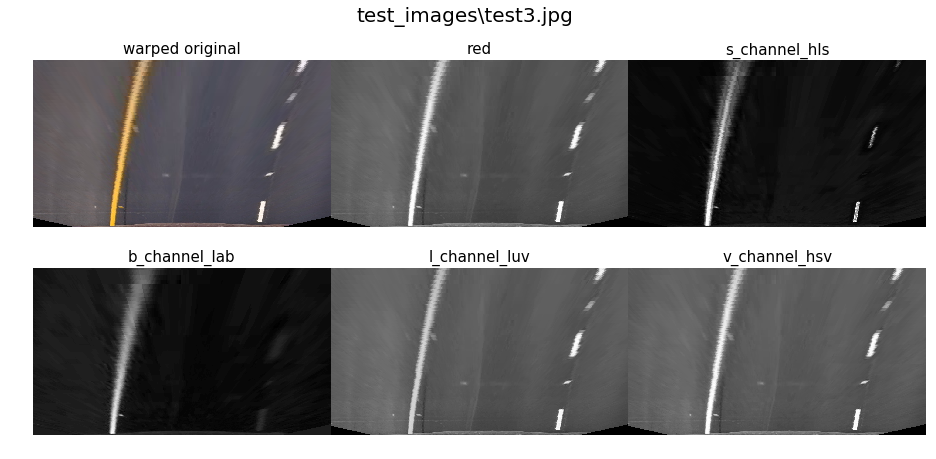

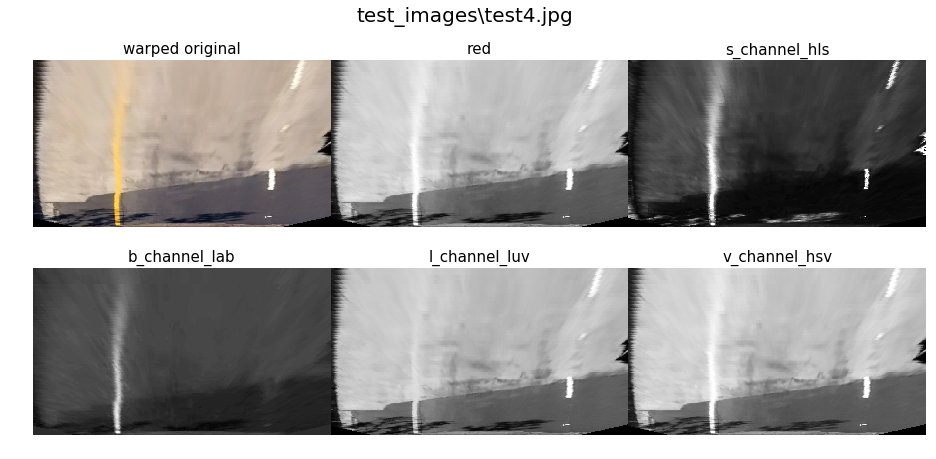

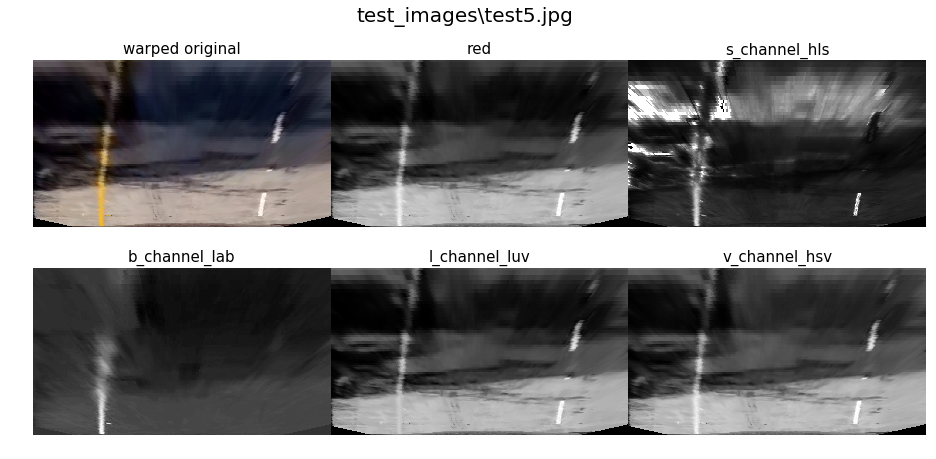

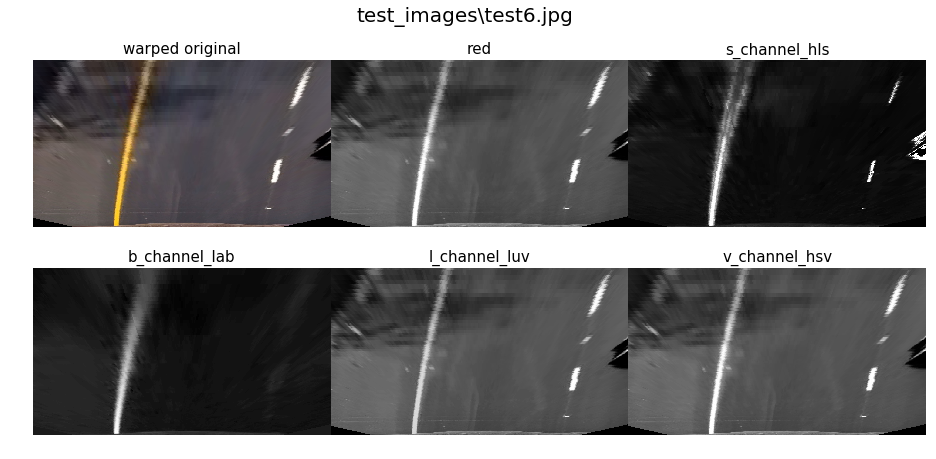

In [37]:
# get the test images from the test_images folder
images = glob.glob('test_images/test*.jpg')

# Loop through each image and send it to the pipeline
for fname in images:
    
    img = mpimg.imread(fname)
    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)
    # warp the image
    warped = warper(undist)

    # Separate the RGB
    R = warped[:,:,0]
    G = warped[:,:,1]
    B = warped[:,:,2]

    # Convert to HLS color space
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel_hls = hls[:,:,0]
    l_channel_hls = hls[:,:,1]
    s_channel_hls = hls[:,:,2]

    # Convert to HSV color space
    hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel_hsv = hsv[:,:,0]
    s_channel_hsv = hsv[:,:,1]
    v_channel_hsv = hsv[:,:,2]

    # Convert to LAB color space
    lab = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab).astype(np.float)
    l_channel_lab = lab[:,:,0]
    a_channel_lab = lab[:,:,1]
    b_channel_lab = lab[:,:,2]
    
    # Convert to LUV color space
    luv = cv2.cvtColor(warped, cv2.COLOR_RGB2Luv).astype(np.float)
    l_channel_luv = luv[:,:,0]
    u_channel_luv = luv[:,:,1]
    v_channel_luv = luv[:,:,2]

    
    ### Plot the source points on the original image and the warped image
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 7))
    f.suptitle(fname, fontsize=20)

    ax1.imshow(warped)
    ax1.set_title('warped original', fontsize=15)
    ax1.axis('off')
    
    ax3.imshow(s_channel_hls, cmap='gray')
    ax3.set_title('s_channel_hls', fontsize=15)
    ax3.axis('off')

    ax2.imshow(R, cmap='gray')
    ax2.set_title('red', fontsize=15)
    ax2.axis('off')

    ax4.imshow(b_channel_lab, cmap='gray')
    ax4.set_title('b_channel_lab', fontsize=15)
    ax4.axis('off')
    
    ax5.imshow(l_channel_luv, cmap='gray')
    ax5.axis('off')
    ax5.set_title('l_channel_luv', fontsize=15)
    
    ax6.imshow(v_channel_hsv, cmap='gray')
    ax6.axis('off')
    ax6.set_title('v_channel_hsv', fontsize=15)

    
    plt.subplots_adjust(hspace = .2, wspace=.001)

In [38]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def calc_sobel(img, sx=False, sy=False, sobel_kernel=5, thresh=(25, 200)):
    
    # Convert to grayscale - sobel can only have one color channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the sobel gradient in x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    if sx:
        abs_sobel = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    elif sy:
        abs_sobel = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    else:
        # Calculate the magnitude 
        mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))

    # Create a binary mask where mag thresholds are me
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1   

    return sxbinary

In [47]:
# Canny edge detector
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def run_canny(img, kernel_size=5, low_thresh=50, high_thresh=150):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply a Gaussian Blur
    gausImage = gaussian_blur(gray, kernel_size)

    # Run the canny edge detection
    cannyImage = canny(gausImage, low_thresh, high_thresh)

    return cannyImage

In [49]:
def applyThreshold(channel, thresh):
    # Create an image of all zeros
    binary_output = np.zeros_like(channel)
    
    # Apply a threshold to the channel with inclusive thresholds 
    binary_output[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return binary_output

# RGB R threshold
def rgb_rthresh(img, thresh=(125, 255)):
    # Pull out the R channel - assuming that RGB was passed in
    channel = img[:,:,0]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

# HLS S threshold
def hls_sthresh(img, thresh=(125, 255)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Pull out the S channel
    channel = hls[:,:,2]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

# LAB B threshold
def lab_bthresh(img, thresh=(125, 255)):
    # Convert to LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # Pull out the B channel
    channel = lab[:,:,2]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

# LUV L threshold
def luv_lthresh(img, thresh=(125, 255)):
    # Convert to LUV
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    # Pull out the L channel
    channel = luv[:,:,0]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

In [50]:
def binaryPipeline(img, show_images=False, \
                   sobel_kernel_size=7, sobel_thresh_low=35, sobel_thresh_high=50, \
                   canny_kernel_size=5 , canny_thresh_low=50, canny_thresh_high=150, \
                   r_thresh_low=225, r_thresh_high=255, \
                   s_thresh_low=220, s_thresh_high=250, \
                   b_thresh_low=175, b_thresh_high=255, \
                   l_thresh_low=215, l_thresh_high=255 \
                  ):
    # Copy the image
    img2 = np.copy(img)

    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)

    # warp the image based on our perspective transform
    warped = warper(undist)
    
    ### COLOR SELECTION
    # Get the Red and saturation images
    r = rgb_rthresh(warped, thresh=(r_thresh_low, r_thresh_high))
    s = hls_sthresh(warped, thresh=(s_thresh_low, s_thresh_high))
    b = lab_bthresh(warped, thresh=(b_thresh_low, b_thresh_high))
    l = luv_lthresh(warped, thresh=(l_thresh_low, l_thresh_high))
    
    ### EDGE DETECTION
    # Run the sobel magnitude calculation
    edge = calc_sobel(warped, sx=True, sobel_kernel=sobel_kernel_size, thresh=(sobel_thresh_low, sobel_thresh_high))
    
    # Run canny edge detector
#     edge = run_canny(warped, kernel_size=canny_kernel_size, low_thresh=canny_thresh_low, high_thresh=canny_thresh_high)
    
    ### Create plots if we want them
    if show_images:
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 7))
        f.tight_layout()
        
        ax1.set_title('r', fontsize=10)
        ax1.axis('off')
        ax1.imshow(r, cmap='gray')
        
        ax2.set_title('s', fontsize=15)
        ax2.axis('off')
        ax2.imshow(s, cmap='gray')
        
        ax3.set_title('b', fontsize=15)
        ax3.axis('off')
        ax3.imshow(b, cmap='gray')

        ax4.set_title('l', fontsize=15)
        ax4.axis('off')
        ax4.imshow(l, cmap='gray')

        ax5.set_title('sobel', fontsize=15)
        ax5.axis('off')
        ax5.imshow(edge, cmap='gray')

    
    # combine these layers
    combined_binary = np.zeros_like(r)
    combined_binary[ (r == 1) | (s == 1) | (b == 1) | (l == 1) | (edge == 1) ] = 1
    
    return combined_binary

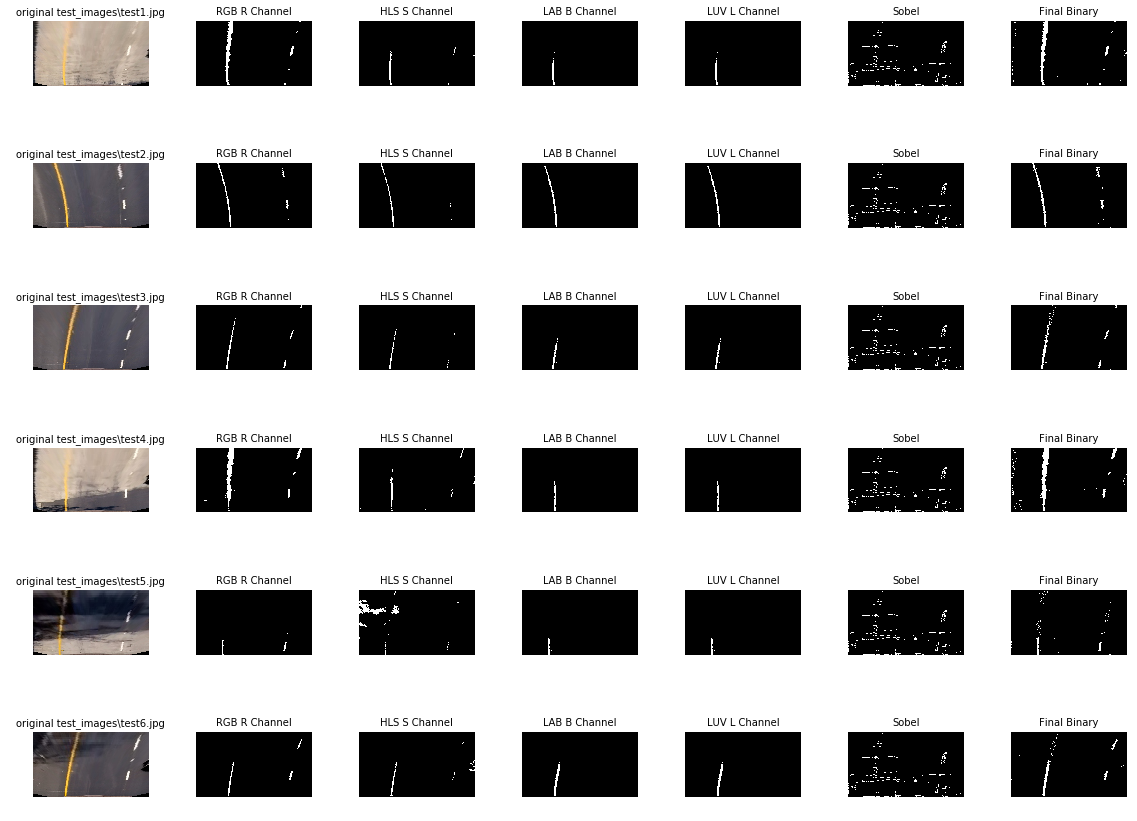

In [53]:
images = glob.glob('test_images/test*.jpg')

f, axs = plt.subplots(6, 7, figsize=(16, 12))
f.tight_layout()
axs = axs.ravel()

i = 0
for fname in images:
    img = mpimg.imread(fname)
    
    # Run this through our binary pipeline
    combined = binaryPipeline(img, show_images=False)
    
    ### The below is just so we can see the makeup of the binary pipeline
    
    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)

    # warp the image
    warped = warper(undist)
    
    canny_kernel_size=5 
    canny_thresh_low=50
    canny_thresh_high=150

    r_thresh_low=225
    r_thresh_high=255

    s_thresh_low=200
    s_thresh_high=255

    b_thresh_low=175
    b_thresh_high=255

    l_thresh_low=225
    l_thresh_high=255
    
    # Get the Red and saturation images
    r = rgb_rthresh(warped, thresh=(r_thresh_low, r_thresh_high))
    s = hls_sthresh(warped, thresh=(s_thresh_low, s_thresh_high))
    b = lab_bthresh(warped, thresh=(b_thresh_low, b_thresh_high))
    l = luv_lthresh(warped, thresh=(l_thresh_low, l_thresh_high))
    
    
    axs[i].axis('off')
    axs[i].imshow(warped)
    axs[i].set_title('original ' + str(fname) , fontsize=10)
    i += 1
    axs[i].axis('off')
    axs[i].imshow(r, cmap='gray')
    axs[i].set_title('RGB R Channel', fontsize=10)
    i += 1
    axs[i].axis('off')
    axs[i].imshow(s, cmap='gray')
    axs[i].set_title('HLS S Channel', fontsize=10)
    i += 1
    axs[i].axis('off')
    axs[i].imshow(b, cmap='gray')
    axs[i].set_title('LAB B Channel', fontsize=10)
    i += 1
    axs[i].axis('off')
    axs[i].imshow(b, cmap='gray')
    axs[i].set_title('LUV L Channel', fontsize=10)
    i += 1
    axs[i].axis('off')
    axs[i].imshow(sobel, cmap='gray')
    axs[i].set_title('Sobel', fontsize=10)
    i += 1
    axs[i].axis('off')
    axs[i].imshow(combined, cmap='gray')
    axs[i].set_title('Final Binary', fontsize=10)
    i += 1

In [101]:
ym_per_pix = 3*8/720 # meters per pixel in y dimension, 8 lines (5 spaces, 3 lines) at 10 ft each = 3m
xm_per_pix = 3.7/550 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters

def calc_line_fits(img):

    ### Settings
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50


    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    #plt.figure()
    #plt.plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, left_fit_m, right_fit_m, out_img

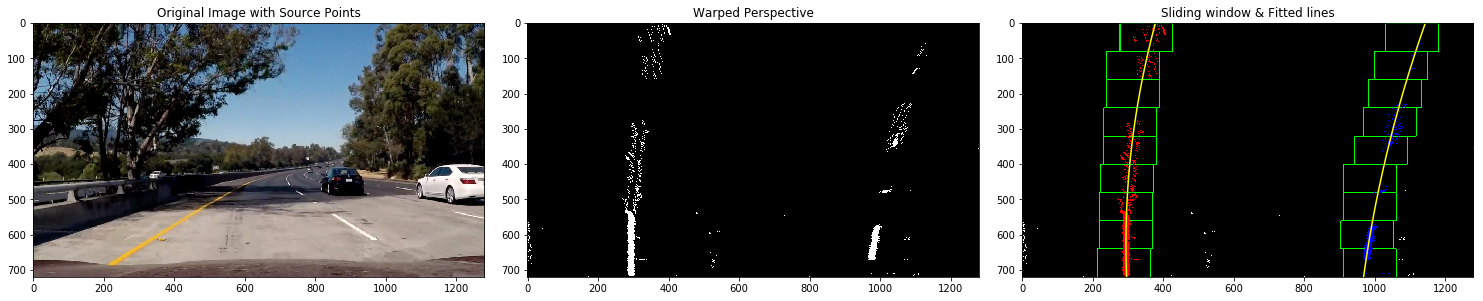

In [102]:
# get the test images from the test_images folder
images = glob.glob('test_images/test5.jpg')


# Loop through each image and send it to the pipeline
for fname in images:
    
    img = mpimg.imread(fname)
    img_og = np.copy(img)
    
    # Run this through our binary pipeline
    binary_warped = binaryPipeline(img)
    
    # Run the warped, binary image from the pipeline through the fitter
    left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(binary_warped)

    ### Plot the original image, the binary warped image, and the visualization from the fitter
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image with Source Points')
    
    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Warped Perspective')
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ax3.imshow(out_img)
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax3.set_title('Sliding window & Fitted lines')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [103]:
def get_center_dist(leftLine, rightLine):
    
    # grab the x and y fits at px 700 (slightly above the bottom of the image)
    y = 700.
    image_center = 640. * xm_per_pix
    
    leftPos = leftLine.best_fit_px[0]*(y**2) + leftLine.best_fit_px[1]*y + leftLine.best_fit_px[2]
    rightPos = rightLine.best_fit_px[0]*(y**2) + rightLine.best_fit_px[1]*y + rightLine.best_fit_px[2]
    lane_middle = int((rightPos - leftPos)/2.)+leftPos
    lane_middle = lane_middle * xm_per_pix
    
    mag = lane_middle - image_center
    if (mag > 0):
        head = "Right"
    else:
        head = "Left"
            
    return head, mag

def combine_radii(leftLine, rightLine):
    
    left = leftLine.radius_of_curvature
    right = rightLine.radius_of_curvature
    
    return np.average([left, right])

In [125]:
def create_final_image(img, binary_warped, leftLine, rightLine, show_images=False):
    
    left_fit = leftLine.best_fit_px
    right_fit = rightLine.best_fit_px
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=20)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp)
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    if show_images:
        plt.figure(figsize=(9,9))
        plt.imshow(color_warp)
        
        plt.figure(figsize=(9,9))
        plt.imshow(result)
    
    return result

def add_image_text(img, radius, head, center):
    
    # Add the radius and center position to the image
    font = cv2.FONT_HERSHEY_COMPLEX
    
    text = 'Radius of curvature: ' + '{:04.0f}'.format(radius) + 'm'
    cv2.putText(img, text, (50,100), font, 1.5, (255,255, 255), 2, cv2.LINE_AA)

    text = 'Vehicle is ' +'{:03.2f}'.format(abs(center)) + 'm '+ head + ' of center'
    cv2.putText(img, text, (50,175), font, 1.5, (255,255, 255), 2, cv2.LINE_AA)
    
    return img

In [126]:
def final_pipeline(img):
    
    img_og = np.copy(img)
    
    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)
    
    # warp the image based on our perspective transform
    warped = warper(undist)
    
    # Run this through our binary pipeline
    binary_warped = binaryPipeline(img)
    
    # If we found lines previously, run the simplified line fitter
    if leftLine.detected == True and rightLine.detected == True:
        left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits_from_prev(binary_warped, leftLine, rightLine)
    else:
        # Run the warped, binary image from the pipeline through the complex fitter
        left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(binary_warped)
    
    
    # Add these fits to the line classes
    leftLine.add_new_fit(left_fit, left_fit_m)
    rightLine.add_new_fit(right_fit, left_fit_m)
    
    # get radius and center distance
    curve_rad = combine_radii(leftLine, rightLine)
    head, center = get_center_dist(leftLine, rightLine)

    # create the final image
    result = create_final_image(img, binary_warped, leftLine, rightLine)
    
    # add the text to the image 
    result = add_image_text(result, curve_rad, head, center)
    
    return result

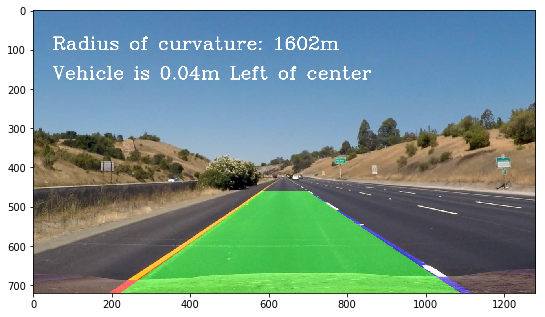

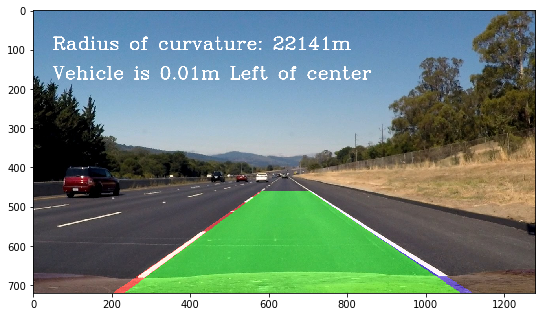

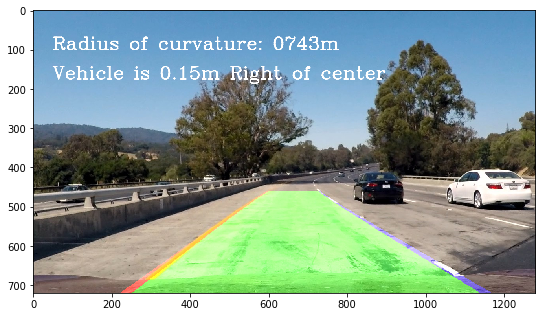

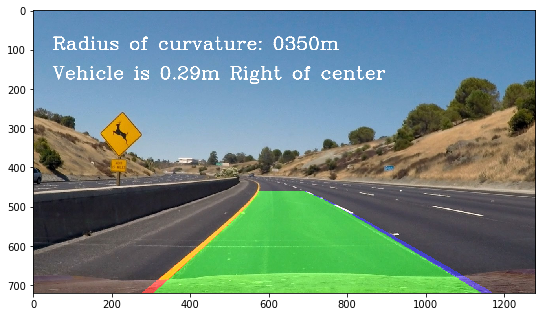

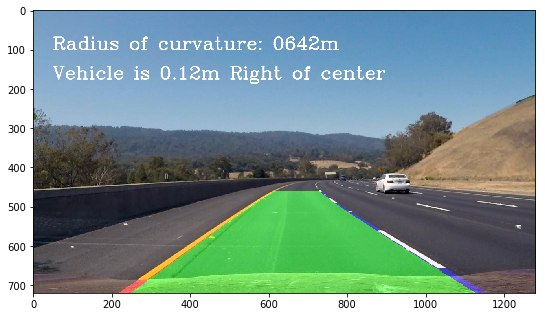

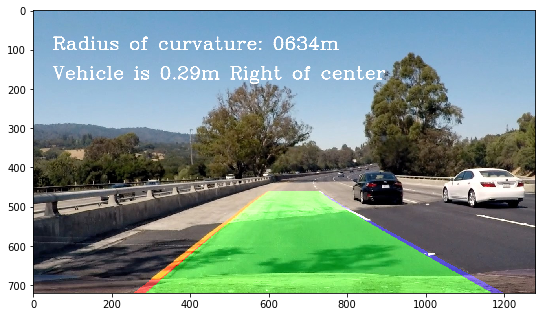

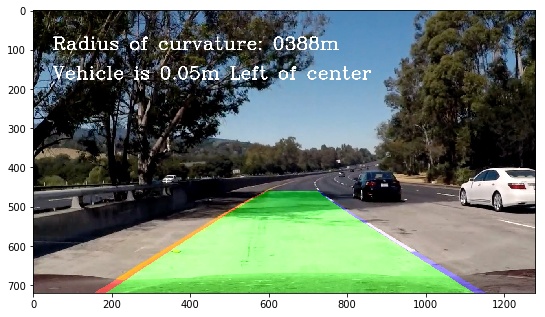

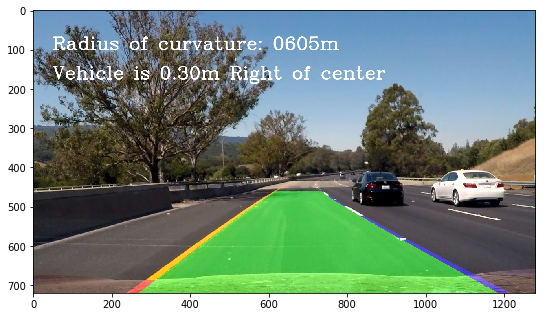

In [127]:
images = glob.glob('test_images/*.jpg')

### Loop through each image and send it to the pipeline
for fname in images:
    
    # Initialize two lines for left and right on every image since the images don't
    # come from a continous video
    rightLine = Line()
    leftLine = Line()
    
    # Read the image
    img = mpimg.imread(fname)
    
    # Run the image through the pipeline
    result = final_pipeline(img)

    # Let's plot the image
    plt.figure(figsize=(9,9))
    plt.imshow(result)

In [128]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [129]:
leftLine = Line()
rightLine = Line()

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(final_pipeline)
%time clip.write_videofile(output, audio=False)

OSError: [WinError 6] The handle is invalid